In [1]:
import pandas as pd
import numpy as np



In [2]:
import pandas as pd
df = pd.read_csv('/content/FoodData (1).csv')
df.head()

,Class,Type,Group,Food,Allergy
0,Plant origin,Nut and seed,Oil seed,Almond,Nut Allergy
1,Plant origin,Fruit,Pome fruit,Apple,Oral Allergy Syndrome
2,Plant origin,Fruit,Stone fruit,Apricot,Stone Fruit Allergy
3,Plant origin,Vegetable,Composite vegetable,Artichoke,Insulin Allergy
4,Plant origin,Vegetable,Liliaceous vegetable,Asparagus,Allium Allergy


In [3]:

# Suppose df is your DataFrame with columns [Class, Type, Group, Food, Allergy].
# Build a dictionary from the "Food" string to the "Allergy" label.

food_allergy_dict = {}
for idx, row in df.iterrows():
    food_key = str(row["Food"]).lower().strip()    # e.g. 'almond'
    allergy_label = row["Allergy"]                 # e.g. 'Nut Allergy'

    if food_key not in food_allergy_dict:
        food_allergy_dict[food_key] = set()
    food_allergy_dict[food_key].add(allergy_label)

# Example:
# {
#   "almond": {"Nut Allergy"},
#   "apple": {"Oral Allergy Syndrome"},
#   "apricot": {"Stone Fruit Allergy"},
#   "artichoke": {"Insulin Allergy"},
#   "asparagus": {"Allium Allergy"}
# }


In [4]:
from transformers import pipeline

pipe = pipeline("token-classification", model="sgarbi/bert-fda-nutrition-ner")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
def get_allergies_from_ingredients(ingredients_text: str):
    """
    Run the BERT NER model on a string of ingredients,
    and check whether recognized tokens match any known allergens.
    Return a list of possible allergy labels.
    """
    # Run the pipeline (NER)
    ner_results = pipe(ingredients_text)

    detected_allergies = set()

    for token_info in ner_results:
        token = token_info["word"]
        token_clean = token.lower().strip()

        # Check if that token matches anything in our dictionary
        if token_clean in food_allergy_dict:
            # If it does, collect all possible allergy labels
            allergies_for_token = food_allergy_dict[token_clean]
            detected_allergies.update(allergies_for_token)

    return list(detected_allergies)


In [6]:
test_ingredients = "Dried apricots, walnuts, honey, lemon juice"

allergies_detected = get_allergies_from_ingredients(test_ingredients)
print("Detected allergies:", allergies_detected)


Detected allergies: ['Nut Allergy', 'Honey Allergy', 'Citrus Allergy']


In [7]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=fbdbb631b585c3a2f52db150ff493c36690da78680c19af6203038cd1fff6b37
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [8]:
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix


=== PREDICTION EXAMPLES ===
Text: Dried apricots, walnuts, honey, lemon juice
Gold Allergies: ['Citrus Allergy', 'Honey Allergy', 'Nut Allergy']
Detected Allergies: ['Nut Allergy', 'Honey Allergy', 'Citrus Allergy']
-----
Text: Apples and almond butter on toast
Gold Allergies: ['Oral Allergy Syndrome', 'Nut Allergy']
Detected Allergies: ['Nut Allergy', 'Milk allergy / Lactose intolerance']
-----
Text: Almond cookies with wheat flour
Gold Allergies: ['Nut Allergy']
Detected Allergies: ['Nut Allergy', 'Gluten Allergy']
-----

=== MULTI-LABEL CLASSIFICATION REPORT (ALLERGIES) ===
                                    precision    recall  f1-score   support

                    Citrus Allergy       1.00      1.00      1.00         1
                    Gluten Allergy       0.00      0.00      0.00         0
                     Honey Allergy       1.00      1.00      1.00         1
Milk allergy / Lactose intolerance       0.00      0.00      0.00         0
                       Nut Allergy 

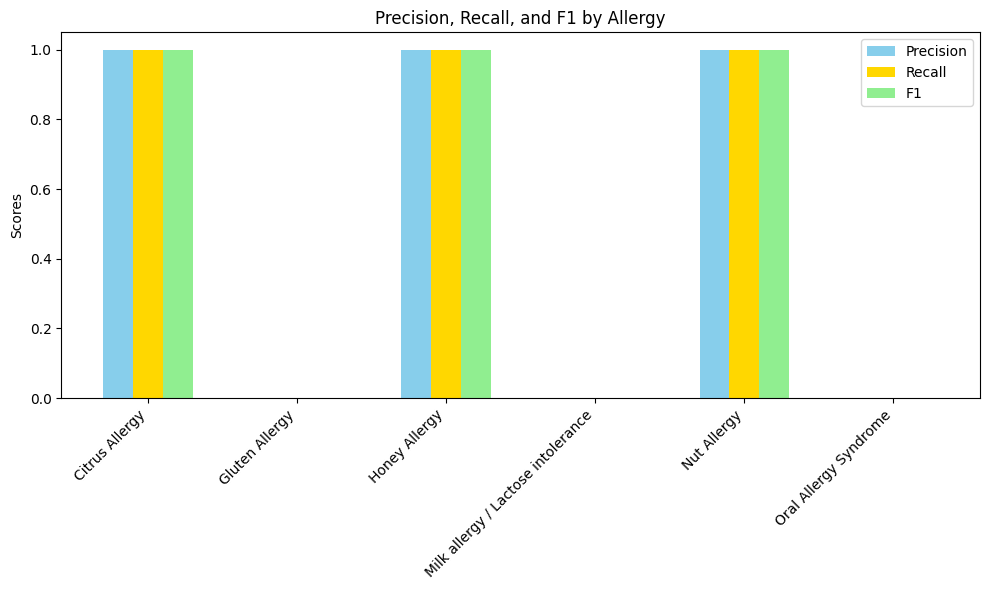

In [10]:

# Each item in 'test_data' is (text, [list_of_true_allergies_for_that_text])
test_data = [
    ("Dried apricots, walnuts, honey, lemon juice", ["Citrus Allergy","Honey Allergy", "Nut Allergy"]),
    ("Apples and almond butter on toast", ["Oral Allergy Syndrome", "Nut Allergy"]),
    ("Almond cookies with wheat flour", ["Nut Allergy"]),  # example if 'wheat' not in your CSV
]

#the predictions and the gold labels
y_true = []  # each element is the list of allergies for that sample
y_pred = []  # each element is the list of predicted allergies for that sample

for text, gold_allergies in test_data:
    predicted_allergies = get_allergies_from_ingredients(text)
    y_true.append(gold_allergies)
    y_pred.append(predicted_allergies)

print("=== PREDICTION EXAMPLES ===")
for (text, gold), pred in zip(test_data, y_pred):
    print(f"Text: {text}")
    print(f"Gold Allergies: {gold}")
    print(f"Detected Allergies: {pred}")
    print("-----")

all_allergies = set()
for gold_allergy_list in y_true:
    all_allergies.update(gold_allergy_list)
for pred_allergy_list in y_pred:
    all_allergies.update(pred_allergy_list)
all_allergies = sorted(list(all_allergies))


def to_binary_vector(allergy_list, all_allergies):
    return [1 if a in allergy_list else 0 for a in all_allergies]

Y_true = [to_binary_vector(a_list, all_allergies) for a_list in y_true]
Y_pred = [to_binary_vector(a_list, all_allergies) for a_list in y_pred]


# use sklearn's classification_report for multi-label data (works OK for micro/macro avg).
report = classification_report(Y_true, Y_pred, target_names=all_allergies, zero_division=0)
print("\n=== MULTI-LABEL CLASSIFICATION REPORT (ALLERGIES) ===")
print(report)

# can also get a confusion matrix for each label (allergy)
cm_matrices = multilabel_confusion_matrix(Y_true, Y_pred)
# cm_matrices[i] is the confusion matrix for all_allergies[i]



lines = report.split("\n")

label_scores = {}
for line in lines:
    for label in all_allergies:
        if line.strip().startswith(label):
            parts = line.split()
            # Usually: [label, precision, recall, f1, support]
            # e.g.: ["Allium", "Allergy", "0.50", "0.66", "0.57", "3"]
            # if label has spaces, the first 'len(label.split())' items are the label
            # Then precision=..., recall=..., f1=..., support=...
            # A quick hack: we can parse from the right side
            p = float(parts[-4])
            r = float(parts[-3])
            f = float(parts[-2])
            label_scores[label] = (p, r, f)
            break

# Now we have label_scores[label] = (precision, recall, f1)
labels = []
precision_vals = []
recall_vals = []
f1_vals = []

for label in all_allergies:
    if label in label_scores:
        (p, r, f) = label_scores[label]
        labels.append(label)
        precision_vals.append(p)
        recall_vals.append(r)
        f1_vals.append(f)

# We'll do a grouped bar chart for precision, recall, and f1
x = np.arange(len(labels))  # label indices
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
bars_p = ax.bar(x - width, precision_vals, width, label='Precision', color='skyblue')
bars_r = ax.bar(x, recall_vals, width, label='Recall', color='gold')
bars_f = ax.bar(x + width, f1_vals, width, label='F1', color='lightgreen')

ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 by Allergy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()


In [14]:
# Compute additional evaluation metrics:
from sklearn.metrics import f1_score, hamming_loss # Import f1_score and hamming_loss
micro_f1 = f1_score(Y_true, Y_pred, average='micro', zero_division=0)
macro_f1 = f1_score(Y_true, Y_pred, average='macro', zero_division=0)
hamming = hamming_loss(Y_true, Y_pred)


micro_f1 = f1_score(Y_true, Y_pred, average='micro', zero_division=0)
macro_f1 = f1_score(Y_true, Y_pred, average='macro', zero_division=0)
hamming = hamming_loss(Y_true, Y_pred)

print(f"Micro-averaged F1: {micro_f1:.3f}")
print(f"Macro-averaged F1: {macro_f1:.3f}")
print(f"Hamming Loss: {hamming:.3f}")

Micro-averaged F1: 0.769
Macro-averaged F1: 0.500
Hamming Loss: 0.167
